# Setup notebook

In [9]:
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import utide

import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.tsa.seasonal import STL
sns.set()

import sys
sys.path.append("..")
from src import features, models
from src import definitions as defs

%load_ext autoreload
%autoreload 2
%matplotlib widget
%config Completer.use_jedi = False

%load_ext rpy2.ipython

os.environ['R_HOME'] = '/home/chris/R/x86_64-pc-linux-gnu-library/4.1/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
wdir = defs.ROOT / "data"

In [3]:
data = pd.read_csv(wdir / "processed" / "sutarkhali_adjusted.csv", index_col="datetime", parse_dates=True, infer_datetime_format=True, squeeze=True).to_frame(name="obs")
data.index = pd.DatetimeIndex(data=data.index, freq="infer")

In [4]:
monthly = data.obs.groupby(by=pd.Grouper(freq="MS")).median()
null_frac = data.obs.groupby(by=pd.Grouper(freq="MS")).apply(lambda x: x.isnull().mean())
monthly.loc[null_frac > 0.3] = np.nan


In [106]:
%%R -o stl_df

.libPaths("/home/chris/R/x86_64-pc-linux-gnu-library/4.1/")

setwd("~/projects/tidal_flat_0d/data/processed")

library(tidyverse)
library(lubridate)
library(tsibble)
library(imputeTS)
library(forecast)


data <- read.csv("sutarkhali_adjusted.csv") |>
  mutate(datetime = ymd_hms(datetime)) |>
  as_tsibble(index = datetime) |>
  fill_gaps()

monthly <- data |>
  index_by(date = ~ yearmonth(.)) |>
  summarize(median = median(obs, na.rm = TRUE), nulls=mean(is.na(obs))) |>
  filter(nulls<0.3) |>
  fill_gaps() |>
  select(date, median) %>%
  mutate(date=decimal_date(as.Date(.$date))) %>%
  {msts(data=.$median, seasonal.periods = c(12), start=.$date[1])} |>
  na_kalman(smooth=TRUE, model="auto.arima")

stl <- mstl(x=monthly, robust = TRUE)

stl_df <- as_tsibble(stl, pivot_longer=FALSE) |>
  mutate(date=as.POSIXct(index))

/opt/conda/envs/python/lib/python3.9/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/opt/conda/envs/python/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:2187: PytzUsageWarning: The zone attribute is specific to pytz's interface; please migrate to a new time zone provider. For more details on how to do so, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  values, tz_parsed = conversion.datetime_to_datetime64(data.ravel("K"))


In [107]:
index = pd.date_range(start=stl_df.date[0], end=stl_df.date[-1], closed=None, freq="MS")

stl_df = stl_df.set_index(index).drop(columns=["index", "date"])
# stl_df.set_index("date")
# stl_df = stl_df.set_index(index=pd.date_range(start))

/opt/conda/envs/python/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:2422: PytzUsageWarning: The zone attribute is specific to pytz's interface; please migrate to a new time zone provider. For more details on how to do so, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  inferred_tz = timezones.infer_tzinfo(start, end)


In [110]:
data.index

DatetimeIndex(['2014-05-17 21:00:00', '2014-05-17 21:10:00',
               '2014-05-17 21:20:00', '2014-05-17 21:30:00',
               '2014-05-17 21:40:00', '2014-05-17 21:50:00',
               '2014-05-17 22:00:00', '2014-05-17 22:10:00',
               '2014-05-17 22:20:00', '2014-05-17 22:30:00',
               ...
               '2018-10-03 10:50:00', '2018-10-03 11:00:00',
               '2018-10-03 11:10:00', '2018-10-03 11:20:00',
               '2018-10-03 11:30:00', '2018-10-03 11:40:00',
               '2018-10-03 11:50:00', '2018-10-03 12:00:00',
               '2018-10-03 12:10:00', '2018-10-03 12:20:00'],
              dtype='datetime64[ns]', name='datetime', length=230349, freq='10T')

In [23]:
fig, ax = plt.subplots(figsize=(13, 5), constrained_layout=True)


,week,mean
1,1.0,-0.261490
2,2.0,-0.249593
3,3.0,-0.286134
4,4.0,-0.205625
5,5.0,0.015651
6,6.0,0.120938
7,7.0,0.206538
8,8.0,0.329328
9,9.0,0.214321
10,10.0,0.165956


<AxesSubplot:xlabel='datetime'>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
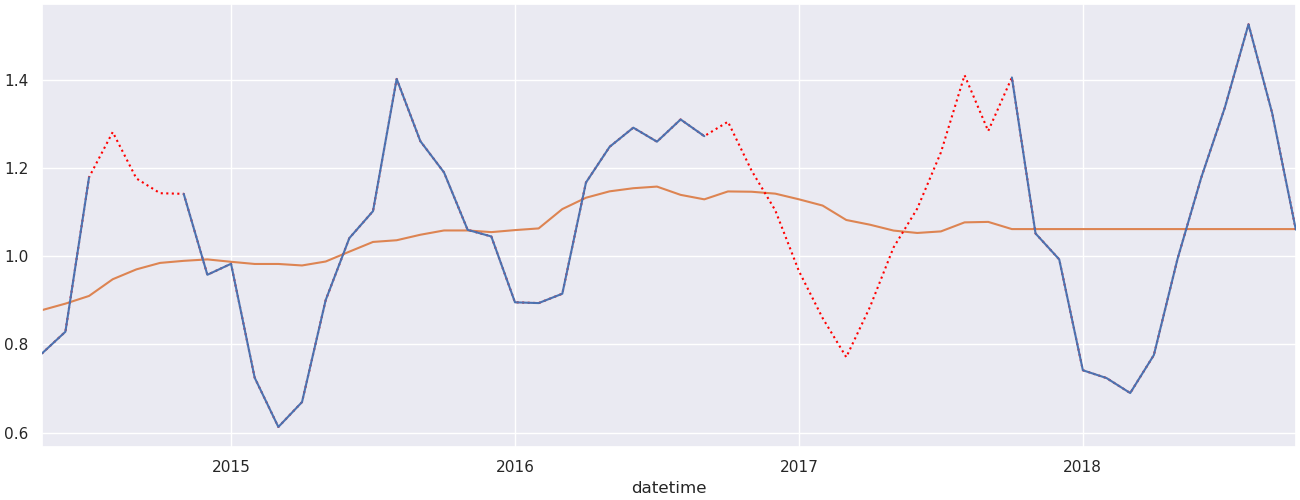

In [143]:
fig, ax = plt.subplots(figsize=(13, 5), constrained_layout=True)

monthly = data.obs.groupby(by=pd.Grouper(freq="MS")).median()
null_frac = data.obs.groupby(by=pd.Grouper(freq="MS")).apply(lambda x: x.isnull().mean())
monthly.loc[null_frac > 0.3] = np.nan
monthly.plot(ax=ax, zorder=10)

trend = monthly.rolling(window=pd.Timedelta("365.25D") * 2, center=True).mean()
trend.plot(ax=ax)

monthly = monthly - trend
mean_monthly = monthly.groupby(monthly.index.month).mean()
monthly.loc[monthly.isnull()] = mean_monthly.loc[monthly.loc[monthly.isnull()].index.month].values
monthly = monthly + trend

monthly.plot(ax=ax, color="red", ls=":")


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
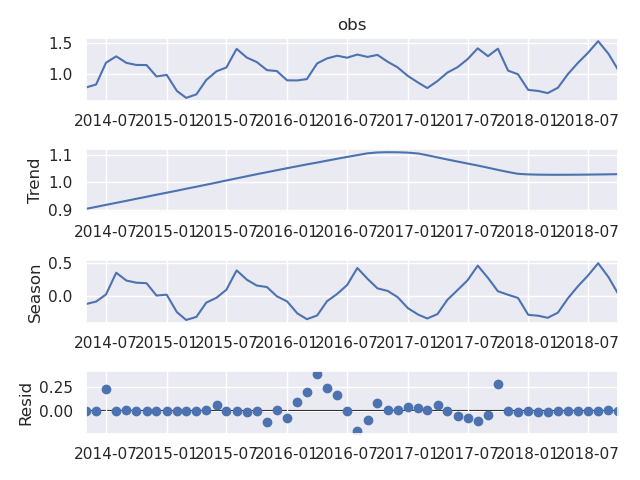

In [126]:
stl = STL(endog=monthly, seasonal=13, robust=True)
res = stl.fit()

data["seasonal"] = res.seasonal.reindex(index=data.index).interpolate(limit_direction="both")
data["trend"] = res.trend.reindex(index=data.index).interpolate(limit_direction="both")
mean_seasonal = data.seasonal.groupby(data.index.month).mean()

res.plot();

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
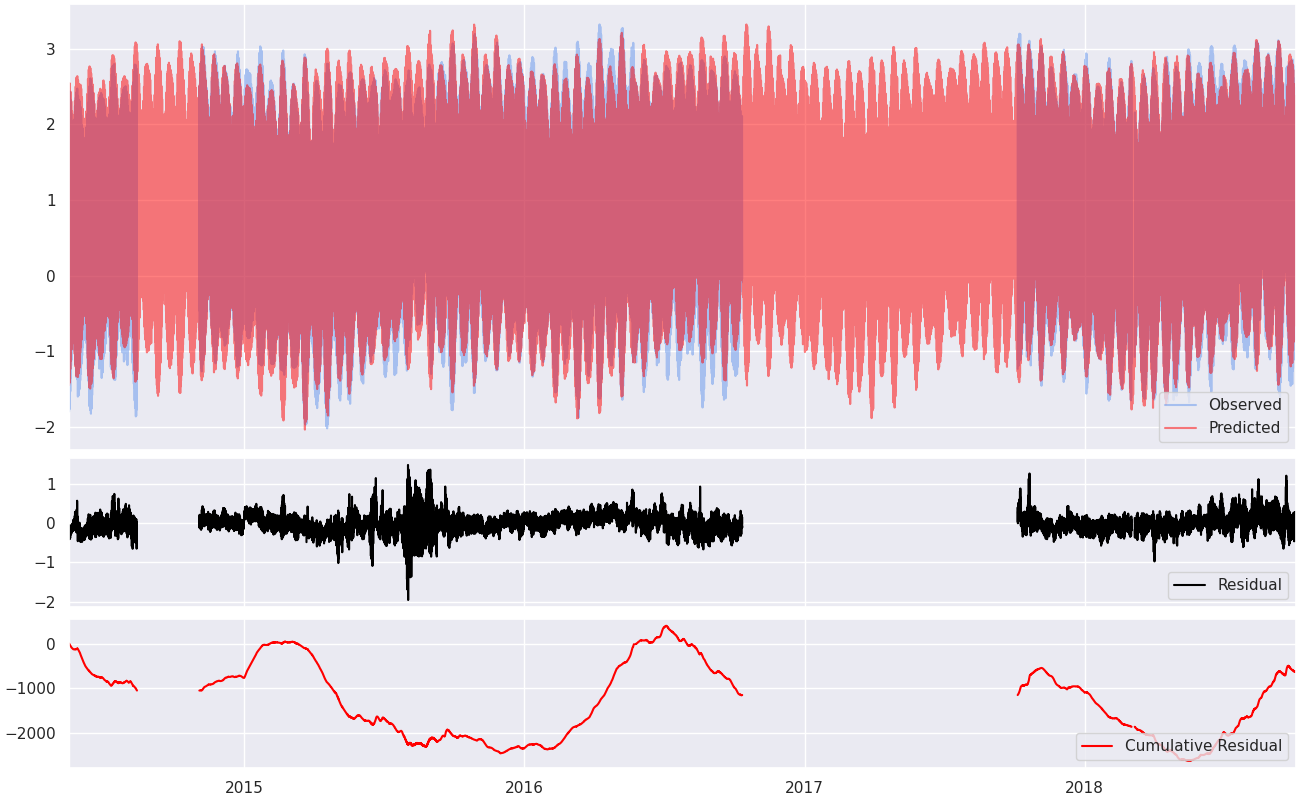

In [128]:
lat = 22.49984514299519
elev = (data.obs - data.trend - data.seasonal).values
time = mdates.date2num((data.index - pd.Timedelta("6 hours")).to_pydatetime())

coef = utide.solve(t=time, u=elev, lat=lat, conf_int="MC", method="ols", trend=False, nodal=True, constit="auto", verbose=False)
data["pred"] = utide.reconstruct(t=mdates.date2num((data.index - pd.Timedelta("6 hours")).to_pydatetime()), coef=coef, verbose=False).h + data.trend  + data.seasonal #+ mean_seasonal.loc[data.index.month].values
data["res"] = data.obs - data.pred

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(13, 8), nrows=3, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]}, constrained_layout=True)

step = 6

data.iloc[::step].obs.plot(kind="line", color="cornflowerblue", alpha=0.5, ax=ax1, label="Observed", legend=True)
data.iloc[::step].pred.plot(kind="line", color="red", alpha=0.5, ax=ax1, label="Predicted", legend=True)
data.iloc[::step].res.plot(kind="line", ax=ax2, color="black", label="Residual", legend=True)
data.res.cumsum().iloc[::step].plot(kind="line", ax=ax3, color="red", label="Cumulative Residual", legend=True)

ax3.set_xlim(data.index[0], data.index[-1]);
ax3.set_xlabel("");

ax1.legend(loc='lower right')
ax2.legend(loc='lower right')
ax3.legend(loc='lower right')

In [134]:
springs

NameError: name 'springs' is not defined

<AxesSubplot:>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
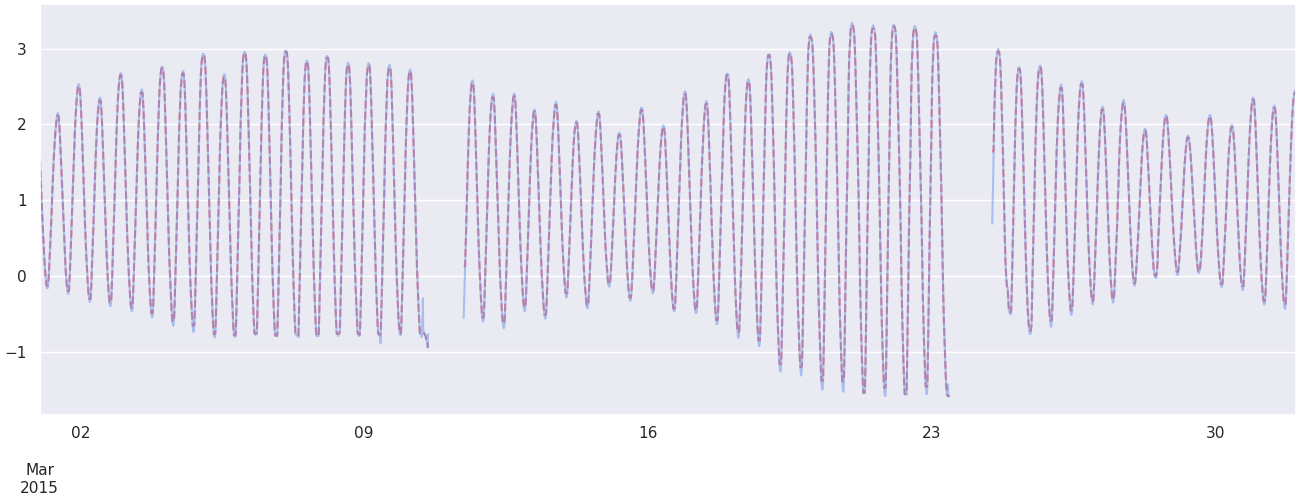

In [ ]:
fig, ax = plt.subplots(figsize=(13, 5), constrained_layout=True)

start = "2015-03"
end = "2015-03"

df = data.to_frame("obs")
df["filt"] = butter_lowpass_filter(data, cutoff, fs, order)

# tides.pred.loc[start:end].plot(ax=ax, alpha=0.5, ls="--", color="red")
df.filt.loc[start:end].plot(ax=ax, color="red", alpha=0.5, ls="--")
tides.obs.loc[start:end].plot(ax=ax, alpha=0.5, color="cornflowerblue")

In [7]:
tides = pd.DataFrame(index=pd.date_range(start="2020", end="2025", closed="left", freq="30S", name="datetime"))
new_time = mdates.date2num((tides.index - pd.Timedelta("6 hours")).to_pydatetime())
tides["elev"] = utide.reconstruct(t=new_time, coef=coef, verbose=False).h + mean_seasonal.loc[tides.index.month].values + trend[-1]

In [35]:
tf = models.TidalFlat(
    tides=tides.elev.loc["2020"],
    land_elev_init=2.55,
    conc_bound=0.3,
    grain_diam=3.0e-5,
    grain_dens=2.65e3,
    bulk_dens=900,
    org_rate_yr=2e-4,
    comp_rate_yr=4e-3,
    sub_rate_yr=3e-3,
)
tf.run()

Progress:   0%|          | 0/365 [00:00<?, ?day/s]

----------------------------------------
Starting elevation:       2.550       m
Final elevation:          2.639       m
Elevation change:         8.942      cm
----------------------------------------
Aggradation:              9.594      cm
Degradation:              0.681      cm
----------------------------------------
Runtime:                    00 min 34 s


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
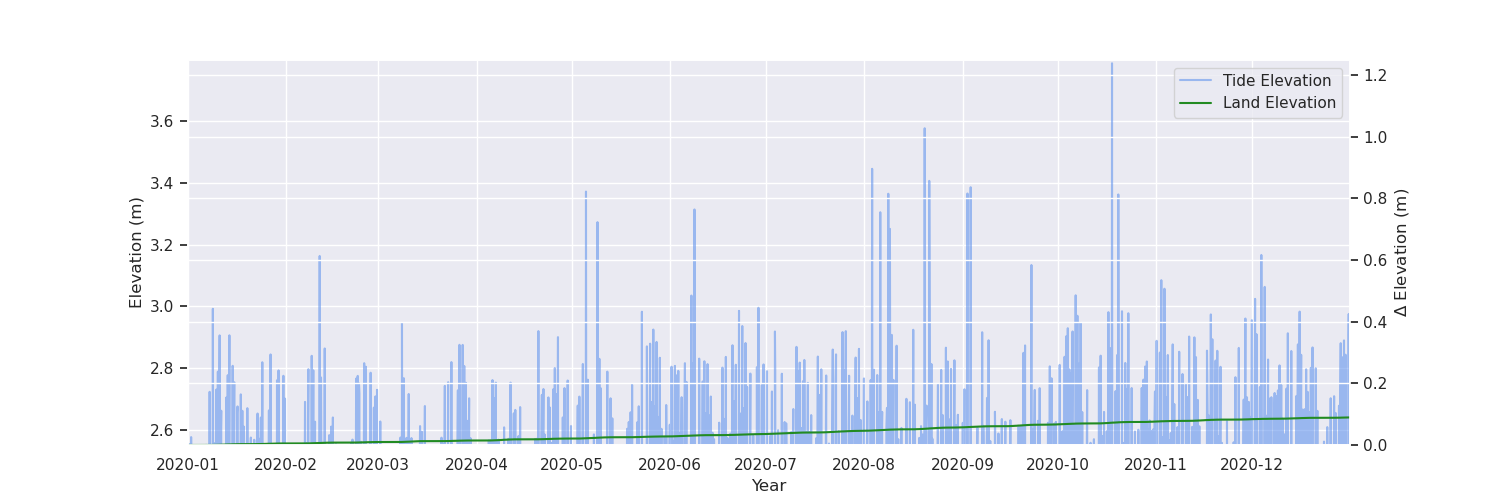

In [38]:
tf.plot(frac=0.01)

<AxesSubplot:xlabel='datetime'>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
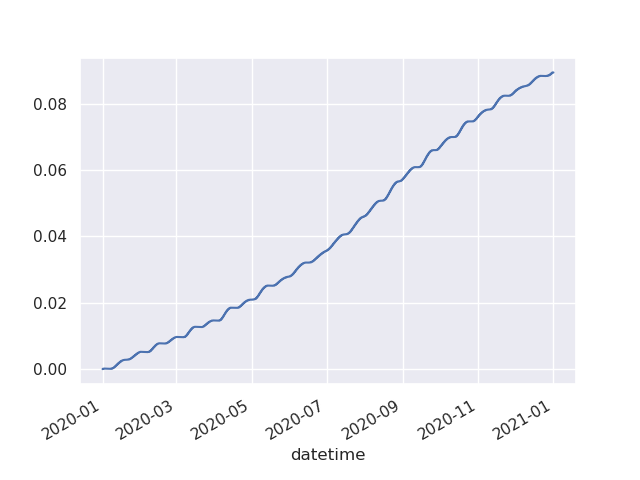

In [47]:
plt.close("all")
df = tf.results.set_index("datetime")
df["land_elev_delta"] = df.land_elev.diff()
df["land_elev_delta_yearly_avg"] = df.land_elev_delta.rolling(window=pd.offsets.Day(365)).sum()
df["land_elev_delta"].cumsum().plot()
# df["land_elev_delta_yearly_avg"].plot()

In [55]:
tides.elev.loc[tides.index.month.isin([6, 7, 8, 9])]

datetime
2020-06-01 00:00:00    0.695887
2020-06-01 00:00:30    0.690889
2020-06-01 00:01:00    0.685901
2020-06-01 00:01:30    0.680923
2020-06-01 00:02:00    0.675957
                         ...   
2024-09-30 23:57:30    3.326450
2024-09-30 23:58:00    3.326293
2024-09-30 23:58:30    3.326112
2024-09-30 23:59:00    3.325908
2024-09-30 23:59:30    3.325680
Name: elev, Length: 1756800, dtype: float64

In [53]:
tides.index.month.isin([6, 7, 8, 9])

array([False, False, False, ..., False, False, False])

In [56]:
tides[["high", "low"]] = False
distance = pd.Timedelta("1H") / tides.index.freq * 8

hi = find_peaks(x=tides.elev.values, distance=distance)[0]
lo = find_peaks(x=tides.elev.values * -1, distance=distance)[0]

tides.loc[tides.iloc[hi].index, "high"] = True
tides.loc[tides.iloc[lo].index, "low"] = True

tides["high_roll"] = tides.loc[tides.high == True].elev.rolling(window=pd.Timedelta("27h"), center=True).mean().reindex(index=tides.index).interpolate(method="time", limit_direction="both")
tides["low_roll"] = tides.loc[tides.low == True].elev.rolling(window=pd.Timedelta("27h"), center=True).mean().reindex(index=tides.index).interpolate(method="time", limit_direction="both")
tides["amp_roll"] = tides.high_roll - tides.low_roll

window = pd.Timedelta("27 hour")
exog = (tides.index - tides.index[0]).total_seconds().astype(int).values
frac = window / pd.Timedelta(tides.index.freq) / len(tides)
# delta = window * 500 / pd.Timedelta(tides.index.freq)
endogs = (tides.high_roll.values, tides.low_roll.values)
high_smooth, low_smooth = Parallel(n_jobs=2, max_nbytes=None)(delayed(sm.nonparametric.lowess)(endog=endog, exog=exog, frac=frac, is_sorted=True) for endog in endogs)

tides.loc[pd.TimedeltaIndex(list(zip(*high_smooth))[0], unit="s") + tides.index[0], "high_smooth"] = list(zip(*high_smooth))[1]
tides.loc[pd.TimedeltaIndex(list(zip(*low_smooth))[0], unit="s") + tides.index[0], "low_smooth"] = list(zip(*low_smooth))[1]
tides["amp_smooth"] = tides.high_smooth - tides.low_smooth

,obs,seasonal,trend,pred,res
datetime,,,,,
2014-05-17 21:00:00,-1.702000,-0.017208,0.851498,-1.502860,-0.199140
2014-05-17 21:10:00,-1.763000,-0.017208,0.851498,-1.527164,-0.235836
2014-05-17 21:20:00,-1.802000,-0.017208,0.851498,-1.527381,-0.274619
2014-05-17 21:30:00,-1.812000,-0.017208,0.851498,-1.502486,-0.309514
2014-05-17 21:40:00,-1.773000,-0.017208,0.851498,-1.451961,-0.321039
...,...,...,...,...,...
2018-10-03 11:40:00,0.184137,-0.001549,1.603235,0.587673,-0.403536
2018-10-03 11:50:00,0.142137,-0.001549,1.603235,0.540197,-0.398060
2018-10-03 12:00:00,0.108137,-0.001549,1.603235,0.499027,-0.390890
